In [64]:
import cv2
import chassisml
import numpy as np
import getpass
import json
import mxnet as mx
import mxnet.image as mxnet_img
from mxnet import gluon, nd
from mxnet.gluon.model_zoo import vision
import matplotlib.pyplot as plt

## Enter credentials
Dockerhub creds and Modzy API Key

In [2]:
dockerhub_user = getpass.getpass('docker hub username')
dockerhub_pass = getpass.getpass('docker hub password')
modzy_api_key = getpass.getpass('modzy api key')

docker hub username········
docker hub password········
modzy api key········


## Load and Test Model from MXNET Gluon Model Zoo

In [5]:
# load model
ctx = mx.cpu()
mobileNet = vision.mobilenet0_5(pretrained=True, ctx=ctx)

In [47]:
# load imagenet labels for postprocessing
imagenet_labels = np.array(json.load(open('data/image_net_labels.json', 'r')))
print(imagenet_labels[4])

# load sample image
filename = "data/dog.jpg"

hammerhead, hammerhead shark


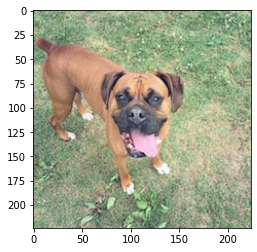

In [67]:
# visualize image to test
image = mx.image.imread(filename)
plt.imshow(image.asnumpy())

In [89]:
# define method for running predictions
def predict(model, image, categories, k=3):
    predictions = model(transform(image)).softmax()
    top_pred = predictions.topk(k=k)[0].asnumpy()
    probs = []
    labels = []
    for index in top_pred:
        probability = predictions[0][int(index)]
        probs.append(probability.asscalar())
        category = categories[int(index)]
        labels.append(category)
    
    return probs, labels

In [90]:
# test model
probs, labels = predict(mobileNet, image, imagenet_labels, 3)
print(probs)
print(labels)

[0.84015656, 0.13626784, 0.006610237]
['boxer', 'bull mastiff', 'Rhodesian ridgeback']


## Prepare context dict
Initialize anything here that should persist across inference runs

In [91]:
# This will be passed to Chassis:
context = {
    "model": mobileNet,
    "labels": imagenet_labels,
    "predict_fn": predict
}

## Write process function

* Must take bytes and context dict as input
* Preprocess bytes, run inference, postprocess model output, return results

In [92]:
def process(input_bytes,context):
    # read image bytes
    img = mxnet_img.imdecode(input_bytes)
    
    # run inference
    probs, labels = context["predict_fn"](context["model"], img, context["labels"], 3)
    
    # structure results
    inference_result = {
        "classPredictions": [
            {"class": labels[i], "score": probs[i]}
        for i in range(len(probs)) ]
    }

    structured_output = {
        "data": {
            "result": inference_result,
            "explanation": None,
            "drift": None,
        }
    }
    return structured_output

## Initialize Chassis Client
We'll use this to interact with the Chassis service

In [93]:
chassis_client = chassisml.ChassisClient("http://localhost:5000")

## Create and test Chassis model
* Requires `context` dict containing all variables which should be loaded once and persist across inferences
* Requires `process_fn` defined above

In [94]:
# create Chassis model
chassis_model = chassis_client.create_model(context=context,process_fn=process)

# test Chassis model locally (can pass filepath, bufferedreader, bytes, or text here):
sample_filepath = './data/dog.jpg'
results = chassis_model.test(sample_filepath)
print(results)

b'{"data":{"result":{"classPredictions":[{"class":"boxer","score":0.8401565551757812},{"class":"bull mastiff","score":0.13626784086227417},{"class":"Rhodesian ridgeback","score":0.0066102370619773865}]},"explanation":null,"drift":null}}'


In [95]:
# test environment and model within Chassis service, must pass filepath here:

# dry run before build
test_env_result = chassis_model.test_env(sample_filepath)
print(test_env_result)

Starting test job... Ok!
{'model_output': 'Single input prediction:\n\nb\'{"data":{"result":{"classPredictions":[{"class":"boxer","score":0.8143024444580078},{"class":"bull mastiff","score":0.16205546259880066},{"class":"Staffordshire bullterrier, Staffordshire bull terrier","score":0.0061945789493620396}]},"explanation":null,"drift":null}}\'\n'}


## Publish model to Modzy
Need to provide model name, model version, Dockerhub credentials, and required Modzy info

In [96]:
response = chassis_model.publish(
    model_name="MXNET MobileNet Image Classifiction",
    model_version="0.0.1",
    registry_user=dockerhub_user,
    registry_pass=dockerhub_pass,
    modzy_sample_input_path=sample_filepath,
    modzy_api_key=modzy_api_key
)

job_id = response.get('job_id')
final_status = chassis_client.block_until_complete(job_id)

Starting build job... Ok!


In [97]:
if chassis_client.get_job_status(job_id)["result"] is not None:
    print("New model URL: {}".format(chassis_client.get_job_status(job_id)["result"]["container_url"]))
else:
    print("Chassis job failed \n\n {}".format(chassis_client.get_job_status(job_id)))

New model URL: https://integration.modzy.engineering/models/bc3cord72v/0.0.1


## Run sample job using Modzy SDK
Submit inference job to our newly-deploy model running on Modzy

In [98]:
from modzy import ApiClient

client = ApiClient(base_url='https://integration.modzy.engineering/api', api_key=modzy_api_key)

input_name = final_status['result']['inputs'][0]['name']
model_id = final_status['result'].get("model").get("modelId")
model_version = final_status['result'].get("version")

inference_job = client.jobs.submit_file(model_id, model_version, {input_name: sample_filepath})
inference_job_result = client.results.block_until_complete(inference_job, timeout=None)
inference_job_results_json = inference_job_result.get_first_outputs()['results.json']
print(inference_job_results_json)

ApiObject({
  "data": {
    "drift": null,
    "explanation": null,
    "result": {
      "classPredictions": [
        {
          "class": "boxer",
          "score": 0.8143022060394287
        },
        {
          "class": "bull mastiff",
          "score": 0.1620550900697708
        },
        {
          "class": "Staffordshire bullterrier, Staffordshire bull terrier",
          "score": 0.00619456497952342
        }
      ]
    }
  }
})
